In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.systems.framework import DiagramBuilder
from pydrake.multibody.parsing import Parser
import os
from pydrake.all import (
    LoadModelDirectives, ProcessModelDirectives, RevoluteJoint, 
    RationalForwardKinematics, CspaceFreePolytope, SeparatingPlaneOrder,
    RigidTransform, RotationMatrix, Rgba,
    AffineSubspace, MathematicalProgram, Solve,
    MeshcatVisualizer, StartMeshcat
)
import numpy as np
# from pydrake.geometry.optimization_dev import (CspaceFreePolytope, SeparatingPlaneOrder)
from iris_plant_visualizer import IrisPlantVisualizer
from pydrake.geometry import Role
from pydrake.geometry.optimization import IrisOptions, HPolyhedron, Hyperellipsoid, IrisInRationalConfigurationSpace, LoadIrisRegionsYamlFile, SaveIrisRegionsYamlFile
from pydrake.solvers import MosekSolver, CommonSolverOption, SolverOptions, ScsSolver
import time

In [4]:
#construct our robot
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.001)
parser = Parser(plant)

parser.package_map().Add("ciris_pgd", os.path.abspath(''))

directives_file = "/home/sgrg/rlg/SUPERUROP/ciris/models/iiwa14_sphere_collision_complex_scenario.dmd.yaml"
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
plant.Finalize()
meshcat = StartMeshcat()
MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
diagram = builder.Build()
q0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyContextFromRoot(context)
plant.SetPositions(plant_context, q0)
diagram.ForcedPublish(context)

INFO:drake:Meshcat listening for connections at http://localhost:7001


In [5]:
q_low = np.array([-2.967060,-2.094395,-2.967060,-2.094395,-2.967060,-2.094395,-3.054326])
q_high = np.array([2.967060,2.094395,2.967060,2.094395,2.967060,2.094395,3.054326])
idx = 0
for joint_index in plant.GetJointIndices():
    joint = plant.get_mutable_joint(joint_index)
    if isinstance(joint, RevoluteJoint):
        joint.set_default_angle(q0[idx])
        joint.set_position_limits(lower_limits= np.array([q_low[idx]]), upper_limits= np.array([q_high[idx]]))
        print(joint)
        idx += 1

<RevoluteJoint name='iiwa_joint_1' index=1 model_instance=2>
<RevoluteJoint name='iiwa_joint_2' index=2 model_instance=2>
<RevoluteJoint name='iiwa_joint_3' index=3 model_instance=2>
<RevoluteJoint name='iiwa_joint_4' index=4 model_instance=2>
<RevoluteJoint name='iiwa_joint_5' index=5 model_instance=2>
<RevoluteJoint name='iiwa_joint_6' index=6 model_instance=2>
<RevoluteJoint name='iiwa_joint_7' index=7 model_instance=2>


In [6]:
Ratfk = RationalForwardKinematics(plant)

# the point about which we will take the stereographic projections
# q_star = np.zeros(plant.num_positions())
q_star = np.array([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
do_viz = True

# The object we will use to perform our certification.
cspace_free_polytope = CspaceFreePolytope(plant, scene_graph, SeparatingPlaneOrder.kAffine, q_star)

In [6]:
from util import *
def AnimateIris(root_context, plant, visualizer, region, speed, num_moves=np.inf):
    """
    A simple hit-and-run-style idea for visualizing the IRIS regions:
    1. Start at the center. Pick a random direction and run to the boundary.
    2. Pick a new random direction; project it onto the current boundary, and run along it. Repeat
    """

    plant_context = plant.GetMyContextFromRoot(root_context)
    visualizer_context = visualizer.GetMyContextFromRoot(root_context)

    q = region.ChebyshevCenter()
    plant.SetPositions(plant_context, q)
    visualizer.ForcedPublish(visualizer_context)
    active_face = None

    print("Press the 'Stop Animation' button in Meshcat to continue.")
    meshcat.AddButton("Stop Animation", "Escape")

    rng = np.random.default_rng()
    nq = region.A().shape[1]
    prog = MathematicalProgram()
    qvar = prog.NewContinuousVariables(nq, "q")
    prog.AddLinearConstraint(
        region.A(), 0 * region.b() - np.inf, region.b(), qvar
    )
    cost = prog.AddLinearCost(np.ones((nq, 1)), qvar)

    count = 0
    while meshcat.GetButtonClicks("Stop Animation") < 1:
        count += 1
        if meshcat.GetButtonClicks("Stop Animation") > 0:
            break
        direction = rng.standard_normal(nq)
        cost.evaluator().UpdateCoefficients(direction)

        result = Solve(prog)
        assert result.is_success()

        q_next = result.GetSolution(qvar)

        # Animate between q and q_next (at speed):
        # TODO: normalize step size to speed... e.g. something like
        # 20 * np.linalg.norm(q_next - q) / speed)
        for t in np.append(np.arange(0, 1, speed), 1):
            qs = t * q_next + (1 - t) * q
            plant.SetPositions(plant_context, qs)
            if in_collision(plant, scene_graph, visualizer_context, print_collisions=True):
                print("In collision!")
            visualizer.ForcedPublish(visualizer_context)
            time.sleep(0.01)

        q = q_next

    meshcat.DeleteButton("Stop Animation")

In [7]:
# load Savva's regions
iris_regions = LoadIrisRegionsYamlFile("/home/sgrg/rlg/SUPERUROP/ciris/ComplexScenarioRegions.yaml")
iris_regions

{'AboveEverything': <pydrake.geometry.optimization.HPolyhedron at 0x7cce565a85b0>,
 'FrontBin': <pydrake.geometry.optimization.HPolyhedron at 0x7ccded3e3730>,
 'FrontBin-Above': <pydrake.geometry.optimization.HPolyhedron at 0x7ccded3e3470>,
 'LeftBin': <pydrake.geometry.optimization.HPolyhedron at 0x7cce2b7729b0>,
 'LeftBin-Above': <pydrake.geometry.optimization.HPolyhedron at 0x7ccde7bf6530>,
 'LeftShelf-Bottom1': <pydrake.geometry.optimization.HPolyhedron at 0x7ccde7bf64f0>,
 'LeftShelf-Bottom2': <pydrake.geometry.optimization.HPolyhedron at 0x7ccde7bba570>,
 'LeftShelf-Front1': <pydrake.geometry.optimization.HPolyhedron at 0x7ccde7bb98f0>,
 'LeftShelf-Middle1': <pydrake.geometry.optimization.HPolyhedron at 0x7cce5661f670>,
 'LeftShelf-Middle2': <pydrake.geometry.optimization.HPolyhedron at 0x7cce5661fd70>,
 'LeftShelf-Top1': <pydrake.geometry.optimization.HPolyhedron at 0x7cce34094cb0>,
 'LeftShelf-Top2': <pydrake.geometry.optimization.HPolyhedron at 0x7cce28d77d70>,
 'RightBin': <p

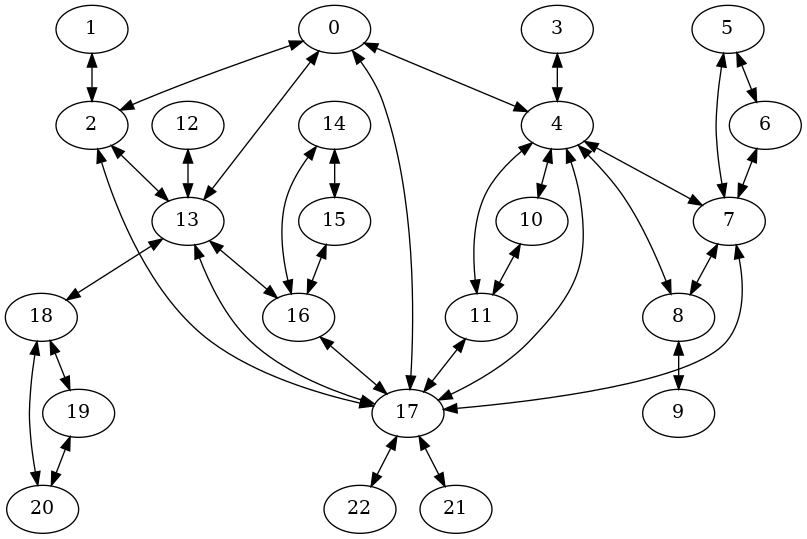

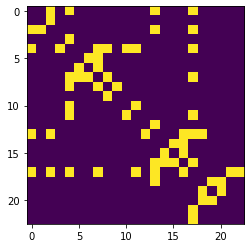

Graph has 1 connected components.


In [8]:
# AnimateIris(context, plant, diagram, iris_regions['AboveEverything'], 0.01, num_moves=100)
list_regions = list(iris_regions.values())
notebook_plot_connectivity(list_regions, plot_dot=True, plot_adj_mat=True)

In [9]:
# get the centers of a few regions and try to grow new regions from them
# 0 -> AboveEverything
# 13 -> RightBin-Above
# 18 - > RightShelf-Front3
# 19 -> RightShelf-Middle1
list_regions[19]
display_iris(build_env, meshcat, directives_file, iris_regions['RightShelf-Middle1'])

([<pydrake.systems.framework.Diagram at 0x7ccdb4a678b0>,
  <pydrake.multibody.plant.MultibodyPlant at 0x7cce345e23f0>])

In [10]:
# Some seedpoints
seed_points_q = np.array([[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]])
regions_to_sample = [0, 13, 18, 19]
for reg_idx in regions_to_sample:
    seed_q = list_regions[reg_idx].ChebyshevCenter()
    seed_points_q = np.append(seed_points_q, [seed_q], axis=0)

seed_points = np.array([Ratfk.ComputeSValue(seed_points_q[idx], q_star)\
                        for idx in range(seed_points_q.shape[0])])

seed_points_q, seed_points

(array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.05196319, -0.36298966, -1.41077147,  0.01736564, -1.16758474,
          0.02361408, -0.30282718],
        [-1.78071519,  0.076419  , -1.3963766 , -0.90066192, -0.30557579,
          0.22455548,  0.03205419],
        [-1.57768368,  0.16345574, -0.78873317, -1.77819833, -2.65086295,
         -1.77819833,  1.85606456],
        [-1.0641467 ,  0.8232019 , -0.419246  , -1.59512707, -0.82336602,
         -1.46539885, -0.71880905]]),
 array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ],
        [ 0.02598744, -0.18351428, -0.85153707,  0.00868304, -0.6606022 ,
          0.01180759, -0.15258141],
        [-1.23550251,  0.03822811, -0.83919609, -0.48346332, -0.153988  ,
          0.11275193,  0.01602847],
        [-1.00691118,  0.08191032, -0.41616852, -1.23232806, -3.99344493,
         -1.23232806,  1.33538274],
        

In [11]:
# generate C-IRIS regions with these seedpoints
default_scale = 1e-2
L1_ball = HPolyhedron.MakeL1Ball(7)
Linf_ball = HPolyhedron.MakeBox(-np.ones(7), np.ones(7))

template_C = np.vstack([L1_ball.A(), Linf_ball.A()])
template_d = np.hstack([default_scale*L1_ball.b(), default_scale/np.sqrt(2)*Linf_ball.b()])


def make_default_polytope_at_point(seed_point):
    return HPolyhedron(template_C, template_d + template_C @ seed_point)


# colors to plot the region.
default_alpha = 0.2
colors_dict = {
    0: Rgba(0.565, 0.565, 0.565, default_alpha), # gray
    1: Rgba(0.118, 0.533, 0.898, default_alpha), # bluish
    2: Rgba(1,     0.757, 0.027, default_alpha), # gold
    3: Rgba(0,     0.549, 0.024, default_alpha), # green   
    4: Rgba(0.055, 0.914, 0.929, default_alpha), # teal 
}

initial_regions = [(make_default_polytope_at_point(s), colors_dict[i]) for i, s in enumerate(seed_points)]

In [11]:
# set up the certifier and the options for different search techniques
solver_options = SolverOptions()
# set this to 1 if you would like to see the solver output in terminal.
solver_options.SetOption(CommonSolverOption.kPrintToConsole, 0)

os.environ["MOSEKLM_LICENSE_FILE"] = "/home/sgrg/mosek.lic"
with open(os.environ["MOSEKLM_LICENSE_FILE"], 'r') as f:
    contents = f.read()
    mosek_file_not_empty = contents != ''
print(mosek_file_not_empty)

solver_id = MosekSolver.id() if MosekSolver().available() and mosek_file_not_empty else ScsSolver.id()


solver_id = MosekSolver.id() if MosekSolver().available() else ScsSolver.id()

True


In [12]:
# The options for when we search for a new polytope given positivity certificates.
find_polytope_given_lagrangian_option = CspaceFreePolytope.FindPolytopeGivenLagrangianOptions()
find_polytope_given_lagrangian_option.solver_options = solver_options
find_polytope_given_lagrangian_option.ellipsoid_margin_cost = CspaceFreePolytope.EllipsoidMarginCost.kGeometricMean
find_polytope_given_lagrangian_option.search_s_bounds_lagrangians = True
find_polytope_given_lagrangian_option.ellipsoid_margin_epsilon = 1e-4
find_polytope_given_lagrangian_option.solver_id = solver_id

bilinear_alternation_options = CspaceFreePolytope.BilinearAlternationOptions()
bilinear_alternation_options.max_iter = 10 # Setting this to a high number will lead to more fill
bilinear_alternation_options.convergence_tol = 1e-3
bilinear_alternation_options.find_polytope_options = find_polytope_given_lagrangian_option

# The options for when we search for new planes and positivity certificates given the polytopes
# find_separation_certificate_given_polytope_options = CspaceFreePolytope.FindSeparationCertificateGivenPolytopeOptions()
# find_separation_certificate_given_polytope_options.num_threads = -1
# Parallelism 	parallelism {Parallelism::Max()}
bilinear_alternation_options.find_lagrangian_options.verbose = True
bilinear_alternation_options.find_lagrangian_options.solver_options = solver_options
bilinear_alternation_options.find_lagrangian_options.ignore_redundant_C = False
bilinear_alternation_options.find_lagrangian_options.solver_id = solver_id

binary_search_options = CspaceFreePolytope.BinarySearchOptions()
binary_search_options.scale_min = 1e-3
binary_search_options.scale_max = 1.0
binary_search_options.max_iter = 5
binary_search_options.find_lagrangian_options.verbose = True
binary_search_options.find_lagrangian_options.solver_options = solver_options
binary_search_options.find_lagrangian_options.ignore_redundant_C = False
binary_search_options.find_lagrangian_options.solver_id = solver_id
# binary_search_options.find_lagrangian_options = find_separation_certificate_given_polytope_options

In [14]:
start = time.perf_counter()
ciris_regions = []
ciris_ellipses = []

iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.configuration_space_margin = 1e-3
iris_options.relative_termination_threshold = 0.001

context_for_iris = context
for i, s in enumerate(seed_points):
    print("seed point ", i, " finished")
    q = Ratfk.ComputeQValue(s, q_star)
    plant.SetPositions(plant.GetMyMutableContextFromRoot(context_for_iris), q)
    r = IrisInRationalConfigurationSpace(plant, 
                                         plant.GetMyContextFromRoot(context_for_iris),
                                         q_star, iris_options)
    ciris_regions.append((r, colors_dict[i]))
    ciris_ellipses.append(r.MaximumVolumeInscribedEllipsoid())
end = time.perf_counter()
print("time taken ", end-start)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1


seed point  0  finished


INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake:IrisInConfigurationSpace iteration 6
INFO:drake:IrisInConfigurationSpace iteration 7
INFO:drake:IrisInConfigurationSpace iteration 8
INFO:drake:IrisInConfigurationSpace iteration 9
INFO:drake:IrisInConfigurationSpace iteration 10
INFO:drake:IrisInConfigurationSpace iteration 11
INFO:drake:IrisInConfigurationSpace iteration 12
INFO:drake:IrisInConfigurationSpace iteration 13
INFO:drake:IrisInConfigurationSpace: Terminating because the hyperellipsoid relative volume change 0.00035609548937206545 is below the threshold 0.001.
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 1


seed point  1  finished


INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking iiwa::Sphere against binR::left has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against binR::left after 56 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking iiwa::Sphere against shelves2::top has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves2::top after 56 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake: Checking iiwa::Sphere against shelves2::top has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves2::top after 55 counter-example searches.
INFO:drake: Checking iiwa::Sphere against shelves::top has already required 50 counter-example searches; still searching...
INFO:drake: Fin

seed point  2  finished


INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking iiwa::Sphere against shelves2::top has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves2::top after 57 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake: Checking iiwa::Sphere against shelves2::top has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves2::top after 54 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake:IrisInConfigurationSpace iteration 6
INFO:drake:IrisInConfigurationSpace iteration 7
INFO:drake:IrisInConfigurationSpace iteration 8
INFO:drake: Checking iiwa::Sphere against binR::left has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against binR::left after 61 counter-example searc

seed point  3  finished


INFO:drake: Finished checking iiwa::Sphere against shelves::shelf_upper after 50 counter-example searches.
INFO:drake: Checking iiwa::Sphere against shelves::top has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves::top after 64 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake: Checking iiwa::Sphere against binR::front has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against binR::front after 57 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking iiwa::Sphere against binR::left has already required 50 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against binR::left after 53 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake: Checking iiwa::Sphere agai

seed point  4  finished


INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace: terminating iterations because the seed point is no longer in the region.


time taken  5757.387652703001


In [ ]:
binary_search_region_certificates_for_iris = dict.fromkeys([tuple(s) for s in seed_points])
for i, (s, (initial_region, color)) in enumerate(zip(seed_points, ciris_regions)):
    print(f"starting seedpoint {i+1}/{len(ciris_regions)}")
    time.sleep(0.2)    
    cert = cspace_free_polytope.BinarySearch(set(),
                                                    initial_region.A(),
                                                    initial_region.b(), 
                                                    initial_region.MaximumVolumeInscribedEllipsoid().center(), 
                                                    binary_search_options)
    binary_search_region_certificates_for_iris[tuple(s)] = [(cert.certified_polytope(), cert, color)]

starting seedpoint 1/5


In [38]:
ciris_regions_proc = [elem[0] for elem in ciris_regions]
ciris_regions_proc_names = ["Origin", "AboveEverything", "RightBin-Above", "RightShelf-Front3", "RightShelf-Middle1"]
regions_dict = dict()
for n, r in zip(ciris_regions_proc_names, ciris_regions_proc):
    regions_dict[n] = r

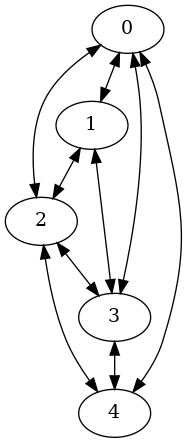

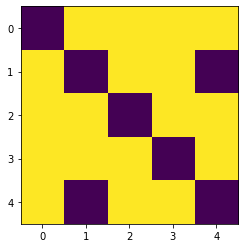

Graph has 1 connected components.


In [18]:
notebook_plot_connectivity(ciris_regions_proc, plot_dot=True, plot_adj_mat=True)

In [32]:
SaveIrisRegionsYamlFile("/home/sgrg/rlg/SUPERUROP/ciris/cirisregions.yaml", regions_dict)

In [66]:
display_iris(build_env, meshcat, directives_file, regions_dict['RightShelf-Middle1'], undistort=True, q_star=q_star)

([<pydrake.systems.framework.Diagram at 0x7ccdac33b5f0>,
  <pydrake.multibody.plant.MultibodyPlant at 0x7ccdb5cdb2f0>])

In [65]:
display_iris(build_env, meshcat, directives_file, iris_regions['RightShelf-Middle1'])

([<pydrake.systems.framework.Diagram at 0x7ccdac31aeb0>,
  <pydrake.multibody.plant.MultibodyPlant at 0x7ccdb4b174b0>])

In [43]:
print(regions_dict)

{'Origin': <pydrake.geometry.optimization.HPolyhedron object at 0x7cce55531330>, 'AboveEverything': <pydrake.geometry.optimization.HPolyhedron object at 0x7ccdb4b64ef0>, 'RightBin-Above': <pydrake.geometry.optimization.HPolyhedron object at 0x7ccdb4abb870>, 'RightShelf-Front3': <pydrake.geometry.optimization.HPolyhedron object at 0x7ccdb41015f0>, 'RightShelf-Middle1': <pydrake.geometry.optimization.HPolyhedron object at 0x7ccdb410d370>}


## Certifying Regions

In [7]:
ciris_regions = LoadIrisRegionsYamlFile("/home/sgrg/rlg/SUPERUROP/ciris/cirisregions.yaml")
ciris_regions

{'AboveEverything': <pydrake.geometry.optimization.HPolyhedron at 0x7dcf68b8e7b0>,
 'Origin': <pydrake.geometry.optimization.HPolyhedron at 0x7dcec96ac9f0>,
 'RightBin-AboveRightShelf-Front3': <pydrake.geometry.optimization.HPolyhedron at 0x7dcf3c35eab0>,
 'RightShelf-Middle1': <pydrake.geometry.optimization.HPolyhedron at 0x7dcec96ad830>}

In [ ]:
binary_search_region_certificates_for_iris = dict.fromkeys([tuple(name) for name in ciris_regions.keys()])
for i, initial_region in enumerate(ciris_regions.values()):
    print(f"starting seedpoint {i+1}/{len(ciris_regions)}")
    time.sleep(0.2)    
    cert = cspace_free_polytope.BinarySearch(set(),
                                                    initial_region.A(),
                                                    initial_region.b(), 
                                                    initial_region.MaximumVolumeInscribedEllipsoid().center(), 
                                                    binary_search_options)
    binary_search_region_certificates_for_iris[tuple(s)] = [(cert.certified_polytope(), cert, color)]

starting seedpoint 1/4
